In [1]:
import time
import random
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from functions import fetch_data, pickle_model
from env import TradingEnvironment

In [2]:
df1 = fetch_data('fb_df')
df2 = fetch_data('aapl_df')
df3 = fetch_data('nflx_df')
df4 = fetch_data('goog_df')
df5 = fetch_data('sp500_df')

---
### Random backtesting

In [ ]:
stocks = {'aapl':df2, 'nflx':df3, 'goog':df4}
#stocks = {'aapl':df2}
starting_balance = 1_000_000

env = TradingEnvironment(stocks, starting_balance)

In [ ]:
done = False
obs = env.reset()
start = env.current_step

agent_performance = []
long_performance = []
rewards = []

while not done:
    
    agent_performance.append(env.agent_portfolio.net_worth)
    long_performance.append(env.long_portfolio.net_worth)
        
    actions = {'aapl':np.random.uniform(-1,1), 'nflx':np.random.uniform(-1,1), 'goog':np.random.uniform(-1,1)}
    #actions = {'aapl':1, 'nflx':1, 'goog':1}
    #actions = {'aapl':np.random.uniform(-1,1)}

    obs, reward, done, info = env.step(actions)
    
    rewards.append(reward)
    

In [ ]:
dates = env.stocks['aapl'].loc[start:env.current_step-1:-1, 'date']

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(dates, agent_performance, label='model')
plt.plot(dates, long_performance, label='long')
plt.legend()

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(rewards)

---
### Training

In [9]:
def build_model(input_shape, output_len):

    h1 = 1024
    #h2 = 584
    h2 = 784
    #h3 = 68
    h3 = 368
    eta = 0.01
    
    model = Sequential()
    
    model.add( # Input layer
        Flatten(
            input_shape=input_shape,
            )
        )
    
    model.add( # Hidden layer 1
        Dense(
            units=h1, 
            activation='relu',
            )
        )

    model.add( # Hidden layer 2
        Dense(
            units=h2, 
            activation='relu',
            )
        )
    
    model.add( # Hidden layer 3
        Dense(
            units=h3, 
            activation='relu',
            )
        )

    model.add( # Output layer
        Dense(
            units=output_len, 
            activation='linear',
            )
        )
    
    model.compile(
        loss='mse',
        optimizer=Adam(lr=eta),
        )
    
    return model   

In [10]:
class DQN:
    
    def __init__(self, action_space, state_space,
        gamma=0.95, memory_size=100_000, batch_size=100, alpha=1.0, alpha_min=0.01, alpha_decay=0.9, n_epochs=20,
        ):
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.alpha = alpha
        self.alpha_min = alpha_min
        self.alpha_decay = alpha_decay
        
        self.action_space = action_space
        self.state_space = state_space
        self.memory = deque(maxlen=memory_size)
        
        self.verbose = 0
        self.is_fit = False
        self.n_epochs = n_epochs
        self.model = build_model(state_space, action_space)
        
    def act(self, state):
        
        # Choose random action (i.e. explore environment) depending on exploration rate
        if np.random.rand() < self.alpha:
            action = np.random.randint(self.action_space)
            
        # Choose action based on maximum q-value depending on exploration rate
        else:
            # If nn is fit, predict the q-values (future reward) for each action given the current state
            if self.is_fit:
                q_values = self.model.predict(
                    state.astype(float).reshape(1, *self.state_space)
                    )
            # If nn is not fit, generate random q_values
            else:
                q_values = [np.random.randn(self.action_space)]
            
            # Choose the action based on the greatest 
            action = np.argmax(q_values[0])
            
        return action
    
    def remember(self, state, action, reward, state_next, terminal):
        
        # Commit to memory the current day's state, the action chosen, the reward received for that action,
        # what the next state is, and whether or not the action had a terminal outcome
        self.memory.append(
            (state, action, reward, state_next, terminal)
            )
        
        return self
    
    def replay(self):
        
        # If memory is smaller than batch size, experience replay can't be done
        if len(self.memory) < self.batch_size:
            return 
        
        X, y = [], []
        # Randomly sample a mini batch from memory to use for training
        mini_batch = random.sample(self.memory, self.batch_size)
                
        # Enumerate each object in the mini batch
        for state, action, reward, state_next, terminal in mini_batch:
            
            # If the current state is terminal, the next state's Q-value is just the current reward
            if terminal:
                q_update = reward
            # If the state is not terminal...
            else:
                # If the nn is fit, approximate the next state's Q-value
                if self.is_fit:
                    q_update = reward + self.gamma*np.amax(
                        self.model.predict(state_next.astype(float).reshape(1, *self.state_space))[0]
                        )
                # If the nn is not fit, the next state's Q-value is just the current reward
                else:
                    q_update = reward
            
            # If the nn is fit, approximate the current state's Q-values
            if self.is_fit:
                q_values = self.model.predict(state.astype(float).reshape(1, *self.state_space))
            # If the nn is not fit, set the current state's Q-values to be zeros
            else:
                q_values = np.zeros((1, self.action_space))
            
            # Update the Q-value of the action chosen at the current state to be the Q-value predicted for the next state
            q_values[0][action] = q_update
                    
            # Add the current observation space and the calculated Q_values to their respective arrays for training
            X.append(state)
            y.append(q_values[0])
            
        # Reformat for nn training
        X = np.array(X).reshape(self.batch_size, *self.state_space)
        y = np.array(y).reshape(self.batch_size, self.action_space)
        
        # Fit nn using the chosen observation spaces and their calculated Q-values
        batch = max(8, int(self.batch_size/8))
        self.is_fit = True
        self.model.fit(
            X.astype(float), 
            y.astype(float), 
            batch_size=batch, 
            epochs=self.n_epochs, 
            verbose=self.verbose,
            )

        # Exploration rate decays by set amount
        self.alpha = max(self.alpha_min, self.alpha*self.alpha_decay)
        
        return X, y 
    

In [11]:
stocks = {'goog':df4}
starting_balance = 1_000_000
env = TradingEnvironment(stocks, starting_balance)

In [12]:
_actions = np.linspace(-1,1, 5)
states = env.observation_space.shape

In [14]:
dqn_solver = DQN(
    action_space=len(_actions),
    state_space=env.observation_space.shape,
    batch_size=3_000,
    memory_size=1_000_000,
    alpha=1.0,
    alpha_decay=0.99,
    alpha_min=0.1,
    gamma=0.99,
    n_epochs=20,
    )

In [15]:
dqn_solver.verbose=1
dqn_solver.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 12)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              13312     
_________________________________________________________________
dense_9 (Dense)              (None, 784)               803600    
_________________________________________________________________
dense_10 (Dense)             (None, 368)               288880    
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 1845      
Total params: 1,107,637
Trainable params: 1,107,637
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = []

In [24]:
for i in np.arange(16, 600):
    
    agent_performance = []
    long_performance = []
    reward_trace = []    
    actions = []
    
    # Reset the evironment at the top of each episode
    state = env.reset()
    done = False    
    
    # Perform experience replay (automatically skips if not enough memory)
    print('\t')
    start = time.time()
    test = dqn_solver.replay()  
    
    # The model will iterate until a terminal state is reached
    while not done:
                
        # Select an action by passing the current observation/state to the DQN
        action = dqn_solver.act(state)
        _action = {'goog': _actions[action]}
        
        # The environment takes a step according to that action and returns the new state, the reward, and the terminal status
        next_state, reward, done, info = env.step(_action)
                
        # Commit to the DQN's memory the relevant information
        dqn_solver.remember(state, action, reward, next_state, done)
        
        # Update the current state
        state = next_state
        
        stop = time.time()

        actions.append(action)
        reward_trace.append(reward)
        agent_performance.append(env.agent_portfolio.net_worth)  
        long_performance.append(env.long_portfolio.net_worth)
            
    print('================================================================================================================')
    print('EPISODE:', i+1)
    print('EXECUTION TIME:', stop - start)
    print('EXPLORATION:', dqn_solver.alpha)
    print('MEMORY SIZE:', len(dqn_solver.memory))
    print('TOTAL REWARD:', np.mean(reward_trace))
    print('FINAL PROFIT:', env.net_worth-env.balance_init)
    print('================================================================================================================')
    
    history.append({
        'agent': agent_performance,
        'long': long_performance,
        'actions': actions,
        'rewards': reward_trace,
        })

X, y = test


	
Train on 3000 samples
Epoch 1/25
3000/3000 [==============================] - 0s 61us/sample - loss: 6.3200
Epoch 2/25
3000/3000 [==============================] - 0s 68us/sample - loss: 6.0971
Epoch 3/25
3000/3000 [==============================] - 0s 73us/sample - loss: 5.9431
Epoch 4/25
3000/3000 [==============================] - 0s 80us/sample - loss: 5.8666
Epoch 5/25
3000/3000 [==============================] - 0s 81us/sample - loss: 5.9915
Epoch 6/25
3000/3000 [==============================] - 0s 77us/sample - loss: 5.8872
Epoch 7/25
3000/3000 [==============================] - 0s 78us/sample - loss: 5.8791
Epoch 8/25
3000/3000 [==============================] - 0s 80us/sample - loss: 5.7926
Epoch 9/25
3000/3000 [==============================] - 0s 88us/sample - loss: 5.7862
Epoch 10/25
3000/3000 [==============================] - 0s 91us/sample - loss: 6.0527
Epoch 11/25
3000/3000 [==============================] - 0s 80us/sample - loss: 5.8437
Epoch 12/25
3000/3000 [=====

3000/3000 [==============================] - 0s 91us/sample - loss: 2.3241
Epoch 6/25
3000/3000 [==============================] - 0s 87us/sample - loss: 2.1947
Epoch 7/25
3000/3000 [==============================] - 0s 86us/sample - loss: 2.0879
Epoch 8/25
3000/3000 [==============================] - 0s 89us/sample - loss: 2.0843
Epoch 9/25
3000/3000 [==============================] - 0s 86us/sample - loss: 2.1043
Epoch 10/25
3000/3000 [==============================] - 0s 87us/sample - loss: 2.0785
Epoch 11/25
3000/3000 [==============================] - 0s 87us/sample - loss: 2.0414
Epoch 12/25
3000/3000 [==============================] - 0s 89us/sample - loss: 2.1097
Epoch 13/25
3000/3000 [==============================] - 0s 89us/sample - loss: 2.1036
Epoch 14/25
3000/3000 [==============================] - 0s 86us/sample - loss: 2.1342
Epoch 15/25
3000/3000 [==============================] - 0s 86us/sample - loss: 2.2147
Epoch 16/25
3000/3000 [==============================] - 0s

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x000001E3B86873A8>
Traceback (most recent call last):
  File "C:\Users\William\anaconda3\envs\deep\lib\site-packages\tensorflow_core\python\data\ops\iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "C:\Users\William\anaconda3\envs\deep\lib\site-packages\tensorflow_core\python\ops\gen_dataset_ops.py", line 1139, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [23]:
dqn_solver.verbose = 1
dqn_solver.n_epochs = 25
dqn_solver.alpha_min = 0.01

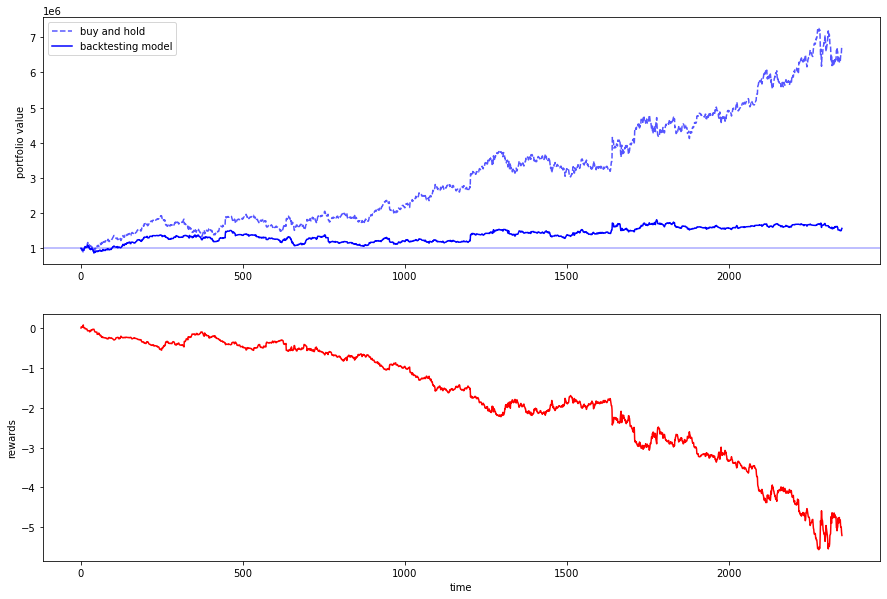

In [25]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

i = -2
X = np.arange(len(history[i]['agent']))

ax1.plot(X, history[i]['long'], 'b--', alpha=0.667, label='buy and hold')
ax1.plot(X, history[i]['agent'], 'b-', label='backtesting model')
ax1.axhline(env.balance_init, alpha=0.333, color='blue')
ax1.set_ylabel('portfolio value')
ax1.legend()

ax2.plot(X, history[i]['rewards'], 'r-')
ax2.set_ylabel('rewards')
ax2.set_xlabel('time')

plt.show();

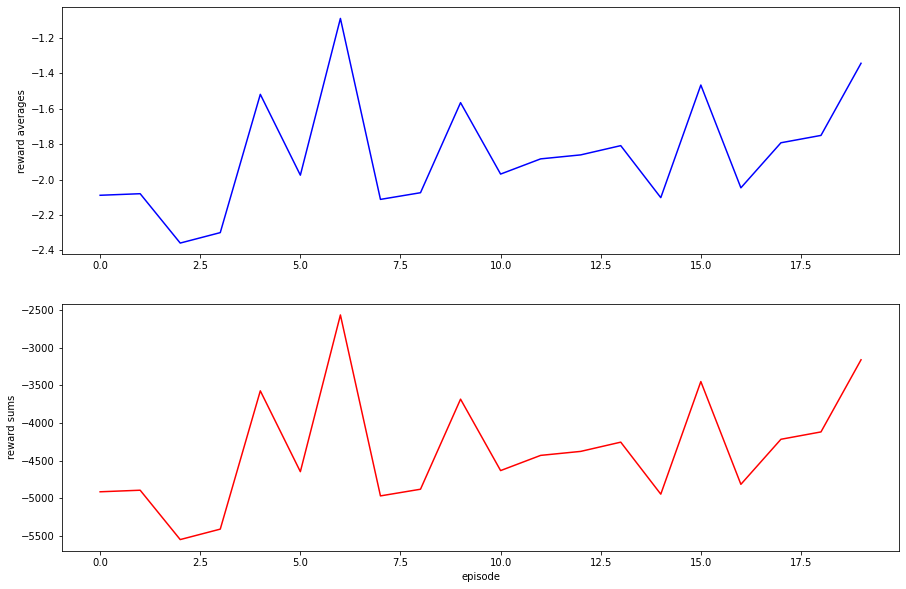

In [26]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

X = np.arange(len(history))
reward_avg = np.array([np.mean(history[i]['rewards']) for i in X])
reward_sum = np.array([sum(history[i]['rewards']) for i in X])

ax1.plot(X, reward_avg, 'b-')
ax1.set_ylabel('reward averages')

ax2.plot(X, reward_sum, 'r-')
ax2.set_ylabel('reward sums')
ax2.set_xlabel('episode')

plt.show();

In [ ]:
pickle_model(dqn_solver, path='base_model_early')